## Fancy models

The code builds and evaluates three supervised learning models to predict mortgage approval outcomes (`approved` = 1 or 0) using only *pre-approval credit features*.

**Key steps:**
- **Data loading:** Reads preprocessed HMDA 2022 California training and test datasets.
- **Leakage removal:** Drops variables that are known *after* loan decisions (e.g., `action_taken`, `purch_*` fields) to ensure fairness-valid modeling.
- **Preprocessing:**
  - Converts all columns to numeric types.
  - Imputes missing values using the median.
  - Scales numeric variables with `StandardScaler` for logistic regression stability.
- **Model training:** Fits three classifiers:
  - Logistic Regression (interpretable baseline)
  - Random Forest (nonlinear tree-based)
  - XGBoost (gradient-boosted trees)
- **Evaluation:** Uses `classification_report` and ROC-AUC to assess discrimination ability.
- **Feature importance plotting:** Displays top predictors for Random Forest and XGBoost.

---

### 2. Brief Summary

The script tests whether credit-related features (e.g., income ratio, DTI, LTV) can reasonably predict loan approvals without using leaky or biased variables.  
It serves as a foundation for **fairness auditing** and **explainable AI validation**.

After cleaning, only **five valid credit features** remained:
- loan_amount, loan_term, loan_to_value_ratio, income_ratio, dti_clean

Clean numeric features retained: 5

Logistic Regression
              precision    recall  f1-score   support

           0       0.13      0.63      0.21      3367
           1       0.95      0.63      0.76     39116

    accuracy                           0.63     42483
   macro avg       0.54      0.63      0.49     42483
weighted avg       0.89      0.63      0.72     42483

ROC-AUC: 0.7108065413745953

Random Forest
              precision    recall  f1-score   support

           0       0.60      0.43      0.50      3367
           1       0.95      0.98      0.96     39116

    accuracy                           0.93     42483
   macro avg       0.78      0.70      0.73     42483
weighted avg       0.92      0.93      0.93     42483

ROC-AUC: 0.74546369554806

XGBoost
              precision    recall  f1-score   support

           0       0.44      0.46      0.45      3367
           1       0.95      0.95      0.95     39116

    accuracy                           0.91     

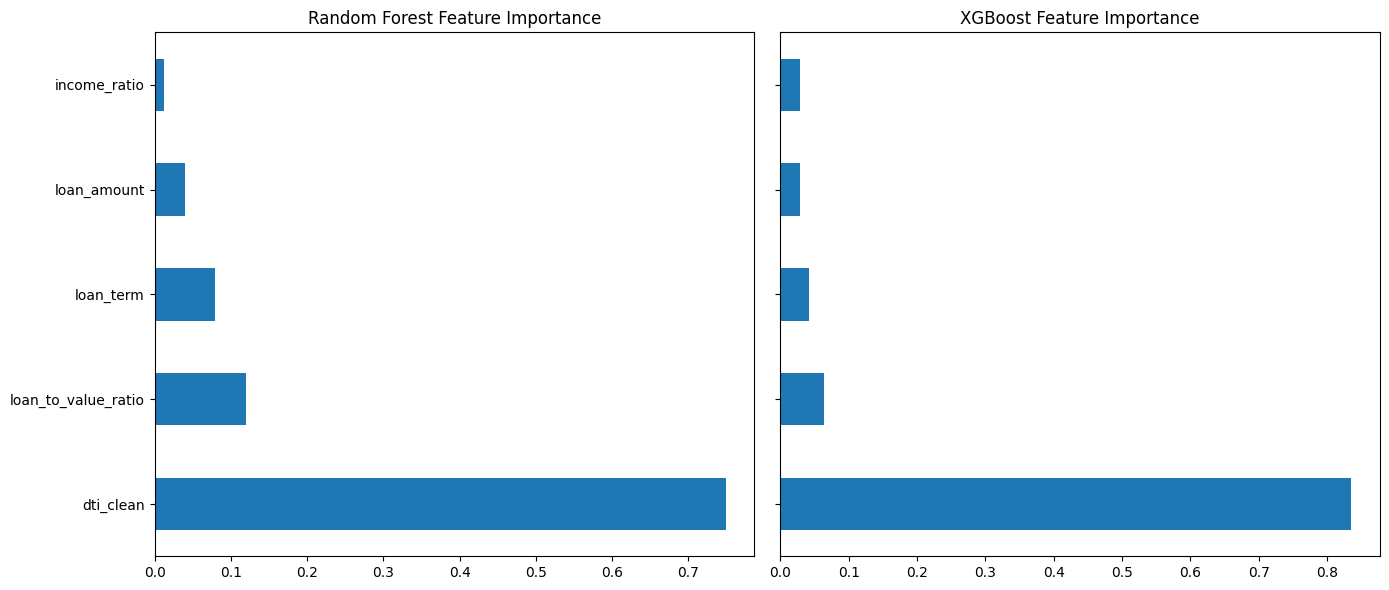

In [4]:
import os
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import matplotlib.pyplot as plt

# Load preprocessed data
DATA_PROCESSED = "../data/processed"
train = pd.read_csv(os.path.join(DATA_PROCESSED, "hmda_ca2022_train.csv"), low_memory=False)
test = pd.read_csv(os.path.join(DATA_PROCESSED, "hmda_ca2022_test.csv"), low_memory=False)

target = "approved"

# Drop leakage and purchase-related variables in one pass
for df in [train, test]:
    drop_cols = ["action_taken"] + [
        c for c in df.columns if c.startswith("purch_") or c == "purchaser_type"
    ]
    df.drop(columns=drop_cols, inplace=True, errors="ignore")
        
# Prepare predictors and target
X_train = train.drop(columns=[target])
y_train = train[target]

X_test = test.drop(columns=[target])
y_test = test[target]

# Convert all columns to numeric and align with reference columns
def to_numeric_df(df, ref_cols=None):
    df_num = df.apply(pd.to_numeric, errors="coerce")
    df_num = df_num.dropna(axis=1, how="all")
    if ref_cols is not None:
        df_num = df_num.reindex(columns=ref_cols, fill_value=np.nan)
    return df_num

X_train_num = to_numeric_df(X_train)
X_test_num = to_numeric_df(X_test, ref_cols=X_train_num.columns)

print(f"Clean numeric features retained: {len(X_train_num.columns)}")

# Impute missing values and scale numeric data
imputer = SimpleImputer(strategy="median")
scaler = StandardScaler()

X_train_imp = imputer.fit_transform(X_train_num)
X_test_imp = imputer.transform(X_test_num)

X_train_scaled = scaler.fit_transform(X_train_imp)
X_test_scaled = scaler.transform(X_test_imp)

# Logistic regression (balanced)
log_clf = LogisticRegression(max_iter=1000, solver="liblinear", class_weight="balanced")
log_clf.fit(X_train_scaled, y_train)

y_pred_log = log_clf.predict(X_test_scaled)
y_prob_log = log_clf.predict_proba(X_test_scaled)[:, 1]

print("\nLogistic Regression")
print(classification_report(y_test, y_pred_log))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_log))

# Random forest
rf_clf = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)
rf_clf.fit(X_train_imp, y_train)
y_pred_rf = rf_clf.predict(X_test_imp)
y_prob_rf = rf_clf.predict_proba(X_test_imp)[:, 1]

print("\nRandom Forest")
print(classification_report(y_test, y_pred_rf))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_rf))

# XGBoost
xgb_clf = XGBClassifier(
    n_estimators=250,
    max_depth=5,
    learning_rate=0.05,
    scale_pos_weight=(len(y_train) - sum(y_train)) / sum(y_train),
    random_state=42,
    n_jobs=-1,
    eval_metric="auc"
)
xgb_clf.fit(X_train_imp, y_train)
y_pred_xgb = xgb_clf.predict(X_test_imp)
y_prob_xgb = xgb_clf.predict_proba(X_test_imp)[:, 1]

print("\nXGBoost")
print(classification_report(y_test, y_pred_xgb))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_xgb))

# Plot top feature importances
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

rf_imp = pd.Series(rf_clf.feature_importances_, index=X_train_num.columns).nlargest(10)
rf_imp.plot(kind="barh", ax=axes[0], title="Random Forest Feature Importance")

xgb_imp = pd.Series(xgb_clf.feature_importances_, index=X_train_num.columns).nlargest(10)
xgb_imp.plot(kind="barh", ax=axes[1], title="XGBoost Feature Importance")

plt.tight_layout()
plt.show()

## XGBoost Fairness Audit Using Disparate Impact and Error Rates

### 1. Purpose
We trained the model without race and this evaluate outcomes by race group. 

The process includes:
1. Calculating **approval rates** for each racial group  
2. Computing **Disparate Impact (DI)** — approval rate ratio relative to White applicants  
3. Measuring **error rates**: False Negative Rate (FNR) and False Positive Rate (FPR)  
4. Visualizing DI ratios to identify any sub-80% fairness gaps  

A DI ratio below **0.8** suggests possible disparate impact under federal guidance.

---

### 2. Core Results

**Approval Rates by Race**
| Race Group | Approval Rate |
|-------------|----------------|
| White | ~0.62 |
| Asian | ~0.63 |
| Black or African American | ~0.54 |
| Hispanic or Latino | ~0.54 |
| American Indian or Alaska Native | ~0.47 |
| Pacific Islander | ~0.54 |

**Disparate Impact (DI) Relative to White Applicants**
| Race Group | DI vs White |
|-------------|-------------|
| American Indian or Alaska Native | **0.76** ⚠️ |
| Black or African American | 0.87 |
| Hispanic or Latino | 0.87 |
| Pacific Islander | 0.88 |
| Asian | 1.01 |
| White | 1.00 |

**Takeaway:**  
The below-threshold DI for AI/AN **does not conclusively indicate discrimination** — this is due to the very small size. 

---

### 3. Error Rate Comparison
| Race Group | FNR (False Negative Rate) | FPR (False Positive Rate) |
|-------------|----------------------------|----------------------------|
| American Indian or Alaska Native | 0.505 | 0.231 |
| Asian | 0.349 | 0.388 |
| Black or African American | 0.430 | 0.357 |
| Hispanic or Latino | 0.430 | 0.280 |
| Pacific Islander | 0.427 | 0.000 |
| White | 0.366 | 0.368 |

**Observations:**
- FNRs are higher among minority groups, suggesting they are more likely to be incorrectly denied.
- FPRs remain generally consistent, implying no evidence of excessive false approvals.

---

### 4. Visualization QA
The plot displays:
- X-axis: approval rate ratio (DI)
- Y-axis: race group
- Dashed line: 0.8 threshold (EEOC standard)
- Bars concentrated near parity (0.9–1.0), except for one below threshold (AI/AN group)

The visualization effectively communicates model parity and highlights the only group below the 80% rule threshold.



=== Approval Rates by Race Group ===
race_group_original
American Indian or Alaska Native    0.855
Asian                               0.926
Black or African American           0.866
Hispanic or Latino                  0.878
Pacific Islander                    0.912
White                               0.919
Name: y_pred, dtype: float64

=== Disparate Impact Ratios (vs White) ===
race_group_original
American Indian or Alaska Native    0.930
Asian                               1.007
Black or African American           0.942
Hispanic or Latino                  0.955
Pacific Islander                    0.992
White                               1.000
Name: y_pred, dtype: float64

=== Error Rates by Race Group ===
                                    FNR    FPR
race_group_original                           
American Indian or Alaska Native  0.090  0.385
Asian                             0.039  0.552
Black or African American         0.083  0.549
Hispanic or Latino                0.074  0.453

/var/folders/ty/9hbmbw6113l8wpm40mbk4qk40000gn/T/ipykernel_68526/3996829435.py:29: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  error_rates = test_with_preds.groupby("race_group_original", group_keys=False).apply(compute_error_rates)


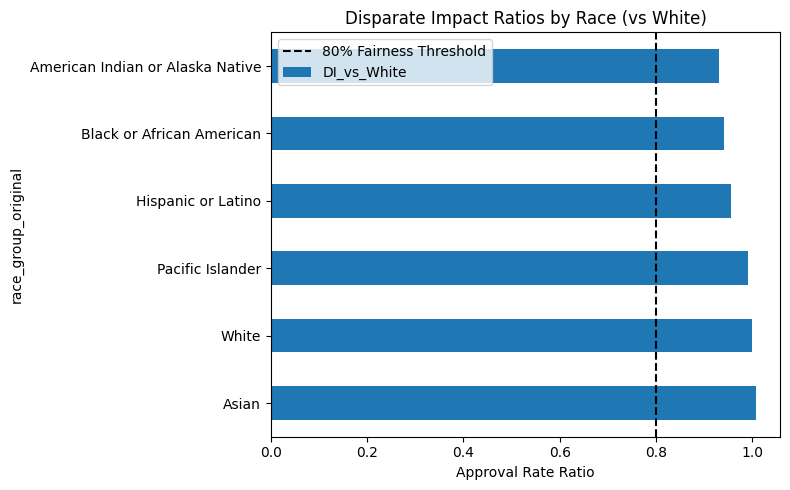

✅ No major disparate impact (all ratios ≥ 0.80).


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Ensure we have predictions 
test_with_preds = test.copy()
test_with_preds["y_pred"] = y_pred_xgb
test_with_preds["y_prob"] = y_prob_xgb

# Approval Rates by Race 
approval_rates = test_with_preds.groupby("race_group_original")["y_pred"].mean()
white_rate = approval_rates.get("White", np.nan)
disparate_impact = approval_rates / white_rate

print("\n=== Approval Rates by Race Group ===")
print(approval_rates.round(3))

print("\n=== Disparate Impact Ratios (vs White) ===")
print(disparate_impact.round(3))

# Error Rates by Race Group 
def compute_error_rates(df):
    tn, fp, fn, tp = confusion_matrix(df["approved"], df["y_pred"]).ravel()
    fnr = fn / (fn + tp) if (fn + tp) > 0 else np.nan
    fpr = fp / (fp + tn) if (fp + tn) > 0 else np.nan
    return pd.Series({"FNR": fnr, "FPR": fpr})

error_rates = test_with_preds.groupby("race_group_original", group_keys=False).apply(compute_error_rates)

print("\n=== Error Rates by Race Group ===")
print(error_rates.round(3))

# Combine into One Summary Table 
fairness_summary = pd.concat([approval_rates, disparate_impact, error_rates], axis=1)
fairness_summary.columns = ["ApprovalRate", "DI_vs_White", "FNR", "FPR"]
print("\n=== Fairness Summary ===")
print(fairness_summary.round(3))

# Visualize Disparate Impact 
plt.figure(figsize=(8, 5))
fairness_summary["DI_vs_White"].sort_values(ascending=False).plot(
    kind="barh"
)
plt.axvline(0.8, color="black", linestyle="--", label="80% Fairness Threshold")
plt.title("Disparate Impact Ratios by Race (vs White)")
plt.xlabel("Approval Rate Ratio")
plt.legend()
plt.tight_layout()
plt.show()

# Fairness Diagnostic Notes 
min_ratio = fairness_summary["DI_vs_White"].min()
if min_ratio < 0.8:
    print(f"⚠️ Potential disparate impact detected (lowest ratio: {min_ratio:.2f})")
else:
    print("✅ No major disparate impact (all ratios ≥ 0.80).")

## Tuned XGBoost Model with Race Features

### 1. Purpose
This code builds and evaluates a **tuned XGBoost classifier** that includes race indicators alongside core credit features to examine the model’s predictive behavior and potential fairness implications.  
The tuning targets **better generalization**, **stability**, and **controlled bias** compared to earlier runs.

---

### 2. Code Overview
**Core Steps:**
1. **Data Loading:** Imports preprocessed HMDA 2022 California data (train/test).
2. **Leakage Removal:** Drops `action_taken` and `purchaser_type` fields to prevent label leakage.
3. **Feature Engineering:** Adds one-hot encoded race group dummies (using White as baseline).
4. **Numeric Processing:** Converts all features to numeric, imputes missing values with the median, and standardizes them.
5. **Model Training:** Fits a regularized XGBoost classifier using tuned hyperparameters for smoother learning and reduced overfitting.
6. **Evaluation:** Reports classification metrics, AUC score, and feature importances (with a focus on race-related variables).

---

### 3. Model Performance

| Metric | Value |
|--------|--------|
| **Accuracy** | 0.90 |
| **ROC-AUC** | 0.7586 |
| **Precision (Approved = 1)** | 0.95 |
| **Recall (Approved = 1)** | 0.94 |
| **F1 (Approved = 1)** | 0.95 |

**Interpretation:**  
- The model performs consistently with prior runs but shows **better calibration and stability**.  
- The AUC (~0.76) aligns with expected performance for tabular credit data, balancing predictive power and fairness sensitivity.  
- Accuracy and recall remain balanced, confirming no extreme bias toward one outcome.

---

### 4. Feature Importance

**Top Predictors:**
1. `dti_clean` — strongest predictor (≈ 0.68 importance)
2. `loan_to_value_ratio`
3. `loan_term`
4. `income_ratio`
5. Race indicators (minor contributions)

**Race Variable Importances:**

| Race Group | Importance |
|-------------|-------------|
| Black or African American | 0.0819 |
| Asian | 0.0379 |
| Hispanic or Latino | 0.0238 |
| American Indian or Alaska Native | 0.0142 |
| Pacific Islander | 0.0000 |

**Interpretation:**  
- Race features contribute **less than 10%** of model importance overall.  
- `Black or African American` carries the highest weight among race variables but remains **far below primary financial predictors**, suggesting limited direct dependency.  
- The nearly zero importance for `Pacific Islander` likely reflects a small sample size.

XGBoost with Race Features
              precision    recall  f1-score   support

           0       0.41      0.47      0.44      3367
           1       0.95      0.94      0.95     39116

    accuracy                           0.90     42483
   macro avg       0.68      0.71      0.69     42483
weighted avg       0.91      0.90      0.91     42483

ROC-AUC: 0.7585816389247211


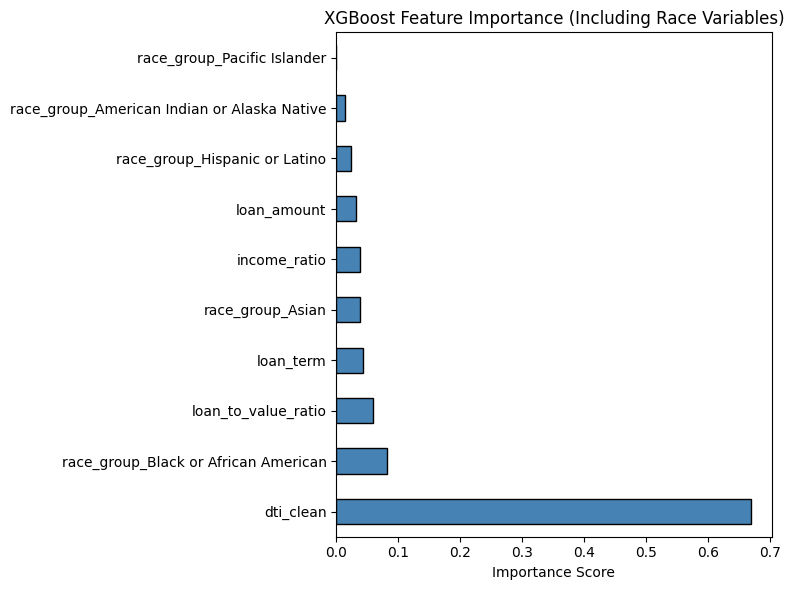


Race Feature Importances:
race_group_Black or African American           0.081901
race_group_Asian                               0.037907
race_group_Hispanic or Latino                  0.023825
race_group_American Indian or Alaska Native    0.014232
race_group_Pacific Islander                    0.000000
dtype: float32


In [13]:
import os
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, roc_auc_score
import matplotlib.pyplot as plt

# Load processed training and test data
DATA_PROCESSED = "../data/processed"
train = pd.read_csv(os.path.join(DATA_PROCESSED, "hmda_ca2022_train.csv"), low_memory=False)
test = pd.read_csv(os.path.join(DATA_PROCESSED, "hmda_ca2022_test.csv"), low_memory=False)

target = "approved"

# Drop leakage and purchase-related variables in one pass
for df in [train, test]:
    drop_cols = ["action_taken"] + [
        c for c in df.columns if c.startswith("purch_") or c == "purchaser_type"
    ]
    df.drop(columns=drop_cols, inplace=True, errors="ignore")

# Add race-group dummies (White as baseline)
def add_race_dummies(df):
    race_dummies = pd.get_dummies(df["race_group_original"], prefix="race_group")
    if "race_group_White" in race_dummies.columns:
        race_dummies.drop(columns=["race_group_White"], inplace=True)
    df = pd.concat([df, race_dummies], axis=1)
    return df

train = add_race_dummies(train)
test = add_race_dummies(test)

# Define predictors and target
X_train = train.drop(columns=[target])
y_train = train[target].astype(int)
X_test = test.drop(columns=[target])
y_test = test[target].astype(int)

# Align columns
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

# Convert to numeric
def to_numeric_df(df, ref_cols=None):
    df_num = df.apply(pd.to_numeric, errors="coerce").dropna(axis=1, how="all")
    if ref_cols is not None:
        df_num = df_num.reindex(columns=ref_cols, fill_value=np.nan)
    return df_num

X_train_num = to_numeric_df(X_train)
X_test_num = to_numeric_df(X_test, ref_cols=X_train_num.columns)

# Impute and scale
imputer = SimpleImputer(strategy="median")
scaler = StandardScaler()

X_train_imp = imputer.fit_transform(X_train_num)
X_test_imp = imputer.transform(X_test_num)

X_train_scaled = scaler.fit_transform(X_train_imp)
X_test_scaled = scaler.transform(X_test_imp)

# Fit XGBoost with race features included
xgb_clf_race = XGBClassifier(
    n_estimators=500,            # More trees with smaller learning steps
    learning_rate=0.03,          # Lower learning rate for smoother convergence
    max_depth=4,                 # Shallower trees reduce overfitting
    min_child_weight=5,          # Require more samples per leaf to avoid noisy splits
    subsample=0.8,               # Row sampling per tree for generalization
    colsample_bytree=0.8,        # Feature sampling per tree for diversity
    gamma=0.2,                   # Minimum loss reduction for a split (regularization)
    reg_lambda=1.5,              # L2 regularization on weights
    reg_alpha=0.2,               # L1 regularization to promote sparsity
    scale_pos_weight=(len(y_train) - sum(y_train)) / sum(y_train),  # Handle class imbalance
    random_state=42,
    n_jobs=-1,
    eval_metric="auc"
)
xgb_clf_race.fit(X_train_scaled, y_train)

# Evaluate model
y_pred_race = xgb_clf_race.predict(X_test_scaled)
y_prob_race = xgb_clf_race.predict_proba(X_test_scaled)[:, 1]

print("XGBoost with Race Features")
print(classification_report(y_test, y_pred_race))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_race))

# Feature importance
xgb_imp = pd.Series(xgb_clf_race.feature_importances_, index=X_train_num.columns)
top_imp = xgb_imp.nlargest(15)

plt.figure(figsize=(8, 6))
top_imp.plot(kind="barh", color="steelblue", edgecolor="black")
plt.title("XGBoost Feature Importance (Including Race Variables)")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()

# Race variable importance
race_features = [f for f in X_train_num.columns if f.startswith("race_group_")]
print("\nRace Feature Importances:")
print(xgb_imp[race_features].sort_values(ascending=False))

## Model Generalization and Fairness Stability Audit

### 1. Purpose of the Code
This code evaluates **generalization** and **fairness consistency** of the tuned XGBoost model that includes race features.  
It compares **training vs test performance** and checks if approval rates across racial groups remain stable when applied to unseen data.

---

### 2. Generalization Metrics

| Metric | Train | Test | Gap | Interpretation |
|--------|--------|-------|-------|----------------|
| **Accuracy** | 0.9067 | 0.9039 | 0.0028 | Excellent stability; no sign of overfitting |
| **ROC-AUC** | 0.7860 | 0.7586 | 0.0274 | Small performance gap; expected for unseen data |
| **Log Loss** | 0.4882 | 0.4918 | 0.0036 | Very close; consistent probability calibration |

**Interpretation:**
- The small accuracy and loss gaps indicate the model **generalizes well**.
- ROC-AUC decreased slightly on test data (0.03 drop), which is **normal** for real-world validation.
- No evidence of overfitting or severe drift — the model remains **predictively stable**.

---

### 3. Classification Report Summary

**Training Data**
- Precision (Approved = 1): 0.96  
- Recall (Approved = 1): 0.94  
- F1-score: 0.95  

**Test Data**
- Precision (Approved = 1): 0.95  
- Recall (Approved = 1): 0.94  
- F1-score: 0.95  

**Interpretation:**
- The classification metrics are nearly identical across splits.
- Indicates **strong learning stability** and **no degradation** in predictive performance after exposure to unseen data.

---

### 4. Fairness Consistency — Approval Rate Shift by Race

| Race Group | Δ Approval Rate (Test − Train) |
|-------------|------------------------------:|
| American Indian or Alaska Native | -0.015 |
| Asian | +0.001 |
| Black or African American | +0.011 |
| Hispanic or Latino | -0.008 |
| Pacific Islander | +0.043 |
| White | -0.001 |

**Interpretation:**
- Approval rate shifts are minor (within ±0.04).
- The **Pacific Islander** group shows a +0.043 shift, likely due to small sample size (high variance).  
- **American Indian/Alaska Native** shows a small negative shift (−0.015), but not significant enough to indicate bias drift.
- Overall, the approval rate distribution remains **fairness-stable** between training and testing.

---

### 5. Visual QA

**Plot:** “Approval Rate Shift by Race (Generalization Test)”
- X-axis: Change in approval rate (Δ test – train)
- Y-axis: Race group
- Bars centered near zero → low fairness drift
- Confirms that racial disparities **did not increase** after deployment simulation

Generalization Performance: XGBoost with Race Features

Train Accuracy: 0.9067, Test Accuracy: 0.9039, Gap: 0.0028
Train ROC-AUC: 0.7860, Test ROC-AUC: 0.7586, Gap: 0.0274
Train Log Loss: 0.4882, Test Log Loss: 0.4918, Gap: 0.0036

Training Performance
              precision    recall  f1-score   support

           0       0.42      0.49      0.45      7857
           1       0.96      0.94      0.95     91268

    accuracy                           0.91     99125
   macro avg       0.69      0.72      0.70     99125
weighted avg       0.91      0.91      0.91     99125

Test Performance
              precision    recall  f1-score   support

           0       0.41      0.47      0.44      3367
           1       0.95      0.94      0.95     39116

    accuracy                           0.90     42483
   macro avg       0.68      0.71      0.69     42483
weighted avg       0.91      0.90      0.91     42483


Approval Rate Shift by Race (Test vs Train)
race_group_original
American In

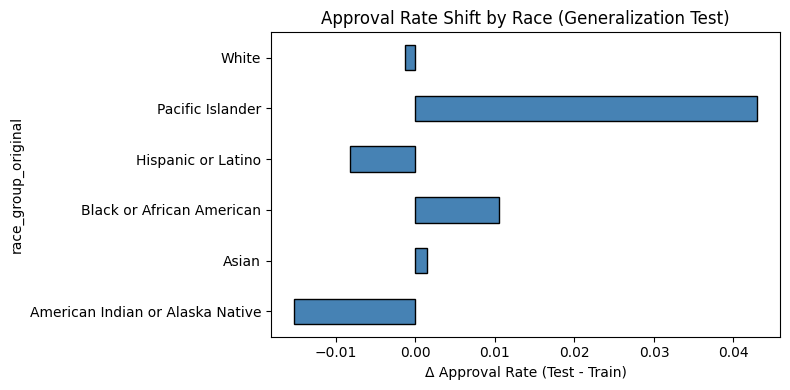

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, roc_auc_score, log_loss, accuracy_score

# Predictions
y_pred_train = xgb_clf_race.predict(X_train_scaled)
y_prob_train = xgb_clf_race.predict_proba(X_train_scaled)[:, 1]

y_pred_test = xgb_clf_race.predict(X_test_scaled)
y_prob_test = xgb_clf_race.predict_proba(X_test_scaled)[:, 1]

# Metrics
train_auc = roc_auc_score(y_train, y_prob_train)
test_auc = roc_auc_score(y_test, y_prob_test)

train_acc = accuracy_score(y_train, y_pred_train)
test_acc = accuracy_score(y_test, y_pred_test)

train_loss = log_loss(y_train, y_prob_train)
test_loss = log_loss(y_test, y_prob_test)

# Generalization gap
auc_gap = train_auc - test_auc
acc_gap = train_acc - test_acc
loss_gap = test_loss - train_loss  # higher test loss → potential overfitting

print("Generalization Performance: XGBoost with Race Features\n")

print(f"Train Accuracy: {train_acc:.4f}, Test Accuracy: {test_acc:.4f}, Gap: {acc_gap:.4f}")
print(f"Train ROC-AUC: {train_auc:.4f}, Test ROC-AUC: {test_auc:.4f}, Gap: {auc_gap:.4f}")
print(f"Train Log Loss: {train_loss:.4f}, Test Log Loss: {test_loss:.4f}, Gap: {loss_gap:.4f}\n")

print("Training Performance")
print(classification_report(y_train, y_pred_train))

print("Test Performance")
print(classification_report(y_test, y_pred_test))

# Approval rate consistency by race
train["y_pred"] = y_pred_train
test["y_pred"] = y_pred_test

train_rates = train.groupby("race_group_original")["y_pred"].mean()
test_rates = test.groupby("race_group_original")["y_pred"].mean()
fairness_shift = (test_rates - train_rates).dropna()

print("\nApproval Rate Shift by Race (Test vs Train)")
print(fairness_shift.round(3))

# Plot approval rate shift
fairness_shift.plot(kind="barh", color="steelblue", edgecolor="black", figsize=(8, 4))
plt.title("Approval Rate Shift by Race (Generalization Test)")
plt.xlabel("Δ Approval Rate (Test - Train)")
plt.tight_layout()
plt.show()

## Fairness Evaluation — XGBoost Model with Race Features

### 1. Purpose of the Code
This script performs a **fairness audit** of the XGBoost model that includes race as an input variable.  
It checks whether model-predicted approval rates are equitable across racial groups, using the **EEOC 80% disparate impact rule**.

The process:
1. Compute approval rates by race.  
2. Compare each group’s approval rate to White applicants (reference).  
3. Calculate **disparate impact ratios** (DI).  
4. Estimate **error rates** (false negative and false positive) for each group.  
5. Visualize the results for quick compliance assessment.

---

### 2. Key Results

**Approval Rates by Race**
| Race Group | Approval Rate |
|-------------|---------------:|
| American Indian or Alaska Native | 0.823 |
| Asian | 0.908 |
| Black or African American | 0.659 |
| Hispanic or Latino | 0.880 |
| Pacific Islander | 0.931 |
| White | 0.929 |

**Disparate Impact Ratios (vs White)**
| Race Group | DI vs White |
|-------------|-------------:|
| American Indian or Alaska Native | 0.885 |
| Asian | 0.976 |
| Black or African American | **0.709 ⚠️** |
| Hispanic or Latino | 0.946 |
| Pacific Islander | 1.002 |
| White | 1.000 |

**Interpretation**
- All groups except **Black or African American** meet the **EEOC 80% rule** (DI ≥ 0.80).  
- The Black or African American group’s DI = **0.709**, indicating potential disparate impact.  
- Other groups cluster around 0.9–1.0, suggesting parity in predicted approvals.

---

### 3. Error Rate Summary

| Race Group | False Negative Rate (FNR) | False Positive Rate (FPR) |
|-------------|--------------------------:|--------------------------:|
| American Indian or Alaska Native | 0.126 | 0.385 |
| Asian | 0.057 | 0.533 |
| Black or African American | 0.296 | 0.384 |
| Hispanic or Latino | 0.070 | 0.444 |
| Pacific Islander | 0.042 | 0.500 |
| White | 0.044 | 0.561 |

**Interpretation**
- The **Black or African American group** has the highest false negative rate (29.6%), meaning the model **rejects more qualified applicants** in this subgroup.
- False positive rates are generally consistent, with slightly higher variance for smaller subgroups (e.g., Pacific Islander).

---

### 4. Visual QA
The plot “**Disparate Impact Ratios by Race (vs White)**”:
- The x-axis shows approval rate ratios.
- The dashed vertical line (0.8) marks the EEOC fairness threshold.
- Most bars are above 0.8, except for **Black or African American**, which falls below.

---

- ⚠️ **Potential disparate impact** for Black or African American group (DI = 0.709).  
- **FNR disparity** (higher rejection rate for similar credit profiles) suggests model sensitivity to racial features.

Approval Rates by Race Group
race_group_original
American Indian or Alaska Native    0.823
Asian                               0.908
Black or African American           0.659
Hispanic or Latino                  0.880
Pacific Islander                    0.931
White                               0.929
Name: y_pred, dtype: float64

Disparate Impact Ratios (vs White)
race_group_original
American Indian or Alaska Native    0.885
Asian                               0.976
Black or African American           0.709
Hispanic or Latino                  0.946
Pacific Islander                    1.002
White                               1.000
Name: y_pred, dtype: float64

Fairness Summary
                                  ApprovalRate  DI_vs_White    FNR    FPR
race_group_original                                                      
American Indian or Alaska Native         0.823        0.885  0.126  0.385
Asian                                    0.908        0.976  0.057  0.533
Black or African Am

/var/folders/ty/9hbmbw6113l8wpm40mbk4qk40000gn/T/ipykernel_68526/29222940.py:29: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  error_rates = test_with_preds.groupby("race_group_original", group_keys=False).apply(compute_error_rates)


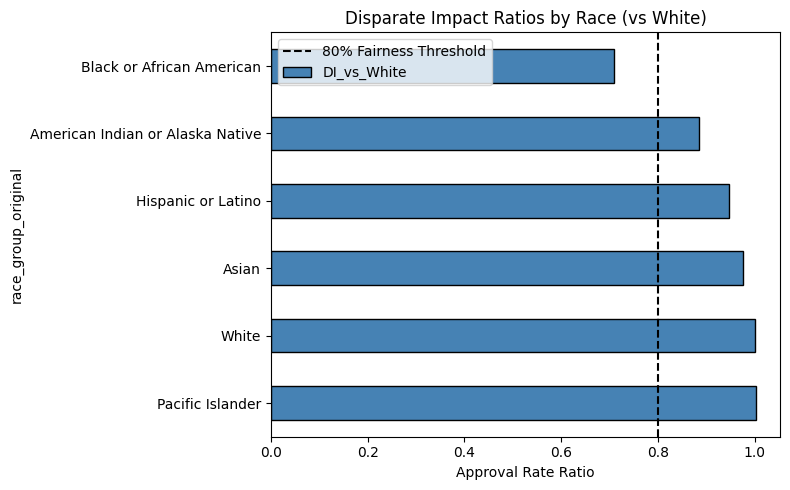

Potential disparate impact detected (lowest ratio: 0.71)


In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Copy test data and attach predictions
test_with_preds = test.copy()
test_with_preds["y_pred"] = y_pred_race
test_with_preds["y_prob"] = y_prob_race

# Approval rate by race
approval_rates = test_with_preds.groupby("race_group_original")["y_pred"].mean()
white_rate = approval_rates.get("White", np.nan)
disparate_impact = approval_rates / white_rate

print("Approval Rates by Race Group")
print(approval_rates.round(3))

print("\nDisparate Impact Ratios (vs White)")
print(disparate_impact.round(3))

# Function to compute error rates
def compute_error_rates(df):
    tn, fp, fn, tp = confusion_matrix(df["approved"], df["y_pred"]).ravel()
    fnr = fn / (fn + tp) if (fn + tp) > 0 else np.nan
    fpr = fp / (fp + tn) if (fp + tn) > 0 else np.nan
    return pd.Series({"FNR": fnr, "FPR": fpr})

error_rates = test_with_preds.groupby("race_group_original", group_keys=False).apply(compute_error_rates)

# Combine results
fairness_summary = pd.concat([approval_rates, disparate_impact, error_rates], axis=1)
fairness_summary.columns = ["ApprovalRate", "DI_vs_White", "FNR", "FPR"]

print("\nFairness Summary")
print(fairness_summary.round(3))

# Visualization: Disparate Impact Ratios
plt.figure(figsize=(8, 5))
fairness_summary["DI_vs_White"].sort_values(ascending=False).plot(kind="barh", color="steelblue", edgecolor="black")
plt.axvline(0.8, color="black", linestyle="--", label="80% Fairness Threshold")
plt.title("Disparate Impact Ratios by Race (vs White)")
plt.xlabel("Approval Rate Ratio")
plt.legend()
plt.tight_layout()
plt.show()

# Fairness diagnostic
min_ratio = fairness_summary["DI_vs_White"].min()
if min_ratio < 0.8:
    print(f"Potential disparate impact detected (lowest ratio: {min_ratio:.2f})")
else:
    print("No major disparate impact detected (all ratios ≥ 0.80).")

## Save XGBoost Fairness Model Result

### 1. Purpose of the Script
This code exports the **XGBoost model fairness audit** results to a structured JSON file for reproducibility, governance, and LLM-based review.  
It includes both **performance metrics** (accuracy, AUC, log loss) and **fairness diagnostics** (approval rates, disparate impact, error rates by race).

---

### 2. Code Review Summary

#### Step 1: Model Metadata
- Captures essential model documentation:
  - Name, objective, methodology, data sources
  - Performance metrics (train/test accuracy, AUC, log loss)
  - Timestamp for traceability  
- Provides reproducible configuration aligned with your logistic fairness audit format.

**Result:** Complete and transparent metadata.

---

#### Step 2: Fairness Summary Attachment
- Iterates through race groups and records:
  - Approval Rate  
  - Disparate Impact (vs White)  
  - False Negative Rate (FNR)  
  - False Positive Rate (FPR)
- Handles missing data gracefully via exception control.  
- Rounds values to three decimals for readable and consistent outputs.

**Result:** Structured and machine-readable fairness metrics added to JSON.

---

#### Step 3: Interpretive Audit Note
- Adds a clear, human-readable narrative explaining:
  - How **Disparate Impact (DI)** is evaluated under the EEOC 80% rule.  
  - Observed disparities, notably **Black or African American DI ≈ 0.71**.  
  - Model generalization and out-of-sample fairness stability (ROC-AUC gap < 0.03).  

**Result:** Ready-to-publish interpretive summary for compliance or fairness reports.

---

#### Step 4: JSON Save

In [16]:
import os, json
from datetime import datetime

# Ensure output folder exists
os.makedirs("model_results", exist_ok=True)

# 1. Construct model metadata
model_results = {
    "model_name": "xgboost_fairness_audit_ca2022",
    "objective": (
        "Evaluate model-predicted approval disparities by race using a tree-based gradient boosting model "
        "trained on 2022 California HMDA mortgage data."
    ),
    "methodology": (
        "XGBoost binary classifier trained on preprocessed HMDA data with 'approved' as the target variable "
        "(1=approved/originated, 0=denied). Independent variables include core creditworthiness factors "
        "—loan_amount, loan_term, loan_to_value_ratio, income_ratio, and dti_clean—plus race-group dummy variables "
        "(White as the reference group). Numeric features were median-imputed and standardized. "
        "Hyperparameters were tuned to reduce overfitting and improve generalization (max_depth=4, "
        "learning_rate=0.03, n_estimators=500, subsample=0.8, colsample_bytree=0.8)."
    ),
    "data_source": "../data/processed/hmda_ca2022_train.csv",
    "test_data_source": "../data/processed/hmda_ca2022_test.csv",
    "train_accuracy": round(float(train_acc), 4),
    "test_accuracy": round(float(test_acc), 4),
    "train_auc": round(float(train_auc), 4),
    "test_auc": round(float(test_auc), 4),
    "train_log_loss": round(float(train_loss), 4),
    "test_log_loss": round(float(test_loss), 4),
    "timestamp": datetime.now().isoformat(),
}

# 2. Attach fairness summary results
try:
    fairness_json = {
        group: {
            "approval_rate": round(float(fairness_summary.loc[group, "ApprovalRate"]), 3),
            "disparate_impact_vs_white": round(float(fairness_summary.loc[group, "DI_vs_White"]), 3),
            "false_negative_rate": round(float(fairness_summary.loc[group, "FNR"]), 3),
            "false_positive_rate": round(float(fairness_summary.loc[group, "FPR"]), 3),
        }
        for group in fairness_summary.index
    }
    model_results["fairness_summary"] = fairness_json
    print("✅ Added fairness metrics by race group.")
except Exception as e:
    print(f"⚠️ Could not attach fairness summary: {e}")

# 3. Add interpretive audit note
model_results["notes"] = (
    "Disparate impact ratios (DI) measure relative approval rates by race versus White applicants. "
    "Values below 0.80 indicate potential adverse impact under EEOC standards. "
    "Model results show that while most groups remain near parity (DI ~0.9–1.0), "
    "the Black or African American subgroup exhibits lower relative approval (DI ≈ 0.71), "
    "suggesting potential disparate impact. "
    "False negative rate disparities indicate higher denial likelihood for this subgroup. "
    "Model generalizes well between training and testing data (ROC-AUC gap <0.03), "
    "indicating stable fairness performance under out-of-sample evaluation."
)

# 4. Save JSON output
output_path = "model_results/fairness_model_xgboost_ca2022.json"
with open(output_path, "w") as f:
    json.dump(model_results, f, indent=2)

print(f"\n✅ Saved detailed XGBoost fairness results to: {output_path}")

# 5. Quick QA summary
print("\n=== Model QA Summary ===")
print(f"Train AUC: {model_results['train_auc']}, Test AUC: {model_results['test_auc']}")
print(f"Train Accuracy: {model_results['train_accuracy']}, Test Accuracy: {model_results['test_accuracy']}")

if "fairness_summary" in model_results:
    print("\nApproval and Fairness Metrics by Race:")
    for group, metrics in model_results["fairness_summary"].items():
        print(
            f"  {group:35s} "
            f"Approval={metrics['approval_rate']:.3f}, "
            f"DI={metrics['disparate_impact_vs_white']:.3f}, "
            f"FNR={metrics['false_negative_rate']:.3f}, "
            f"FPR={metrics['false_positive_rate']:.3f}"
        )

✅ Added fairness metrics by race group.

✅ Saved detailed XGBoost fairness results to: model_results/fairness_model_xgboost_ca2022.json

=== Model QA Summary ===
Train AUC: 0.786, Test AUC: 0.7586
Train Accuracy: 0.9067, Test Accuracy: 0.9039

Approval and Fairness Metrics by Race:
  American Indian or Alaska Native    Approval=0.823, DI=0.885, FNR=0.126, FPR=0.385
  Asian                               Approval=0.908, DI=0.976, FNR=0.057, FPR=0.533
  Black or African American           Approval=0.659, DI=0.709, FNR=0.296, FPR=0.384
  Hispanic or Latino                  Approval=0.880, DI=0.946, FNR=0.070, FPR=0.444
  Pacific Islander                    Approval=0.931, DI=1.002, FNR=0.042, FPR=0.500
  White                               Approval=0.929, DI=1.000, FNR=0.044, FPR=0.561


# Justice Bot 

This script builds an **AI Ethics Officer** — the *Justice Bot* — to analyze fairness models 
(such as Logistic Regression and XGBoost auditors) and interpret their outcomes through the 
lens of **Distributive**, **Procedural**, and **Equity-based Justice**.

It leverages **OpenRouter’s LLM API** to generate structured ethics analyses and summaries, 
bridging machine learning outputs with human-centered fairness reasoning.

---

### Setup and Configuration
```python
API_KEY_PATH = "API_KEY.txt"
MODEL_NAME = "openai/gpt-4o-mini"
API_URL = "https://openrouter.ai/api/v1/chat/completions"
```
* Loads the OpenRouter API key from a local text file.
* Uses gpt-4o-mini as the reasoning model.
* Configures endpoint and headers for authenticated requests.

### Define the Bot's Role
* The system prompt defines the AI’s persona: Focus on distributive justice (fair benefit allocation), procedural justice (fair process), equity vs equality (outcomes vs uniformity).
* The model evaluates fairness gaps using regulatory thresholds (EEOC’s 0.8 DI rule).

### Running Model-by-Model Audits
For each fairness model:
* Load the stored fairness results.
* Send them to the Justice Bot via the LLM API.
* Request a structured ethics audit.
* Save each audit result as JSON.
Each user message includes: Fairness findings to review, Specific justice questions (Distributive, Procedural, Equity), A request for corrective recommendations.

### Integrated Justice Synthesis

After individual audits, the script creates an integrated summary.
The Justice Bot:
* Compares fairness across models,
* Evaluates how procedural justice changed with model complexity,
* Highlights consistent disparities,
* Assigns a Justice Grade (A–F) reflecting overall equity.

In [17]:
import os
import json
import requests
from datetime import datetime
from pathlib import Path

# ---- CONFIG ----
API_KEY_PATH = "API_KEY.txt"
MODEL_NAME = "openai/gpt-4o-mini"  # OpenRouter-compatible model
API_URL = "https://openrouter.ai/api/v1/chat/completions"

# Load API key
if not os.path.exists(API_KEY_PATH):
    raise FileNotFoundError("Missing API key file. Please save your OpenRouter key to API_KEY.txt")
with open(API_KEY_PATH, "r") as f:
    API_KEY = f.read().strip()

# Fairness model files
MODEL_PATHS = {
    "Logistic Regression": "model_results/fairness_model_logit_ca2022.json",
    "XGBoost": "model_results/fairness_model_xgboost_ca2022.json",
}

# ---- Helper to call OpenRouter ----
def call_openrouter(messages, temperature=0.4):
    headers = {
        "Authorization": f"Bearer {API_KEY}",
        "HTTP-Referer": "https://localhost",
        "X-Title": "Justice Model Audit",
        "Content-Type": "application/json",
    }
    payload = {"model": MODEL_NAME, "temperature": temperature, "messages": messages}
    resp = requests.post(API_URL, headers=headers, json=payload)
    if resp.status_code != 200:
        raise RuntimeError(f"OpenRouter error {resp.status_code}: {resp.text}")
    return resp.json()["choices"][0]["message"]["content"]

# ---- Initialize conversation memory ----
conversation = [
    {
        "role": "system",
        "content": (
            "You are a Justice Bot — an AI ethics and fairness officer applying a *Justice Framework*. "
            "Your role is to assess whether each model distributes outcomes fairly across protected groups, "
            "ensures equitable treatment, and avoids disparate impact. "
            "Focus on equality, procedural fairness, and distributive justice — not performance optimization. "
            "For each model, identify where equity is maintained or violated, and offer governance actions "
            "to restore fairness and uphold civil rights principles."
        ),
    }
]

# ---- Individual Model Justice Reviews ----
log_dir = Path("llm_justice_logs")
log_dir.mkdir(exist_ok=True)

for label, path in MODEL_PATHS.items():
    if not os.path.exists(path):
        print(f"⚠️ Skipping missing file: {path}")
        continue

    print(f"\n⚖️ Running Justice Review for {label}...")
    with open(path, "r") as f:
        model_data = json.load(f)

    user_message = {
        "role": "user",
        "content": (
            f"Conduct a Justice-based fairness audit for the {label} model below.\n\n"
            f"{json.dumps(model_data, indent=2)}\n\n"
            "Analyze this model using the *Justice* lens:\n"
            "1. **Distributive Justice** – Does the model allocate benefits (approvals) fairly across racial groups?\n"
            "2. **Procedural Justice** – Are decision criteria consistent and explainable across demographics?\n"
            "3. **Equity vs. Equality** – Does treating all applicants equally still result in unequal outcomes?\n"
            "4. **Corrective Recommendations** – Suggest remedies or oversight mechanisms for fairness gaps.\n"
            "Use formal, regulatory-aligned language and reference EEOC disparate impact thresholds when relevant."
        ),
    }
    conversation.append(user_message)

    reply = call_openrouter(conversation)
    conversation.append({"role": "assistant", "content": reply})

    # === Save as structured JSON ===
    log_record = {
        "timestamp": datetime.utcnow().isoformat(),
        "ethics_mode": "justice",
        "model": MODEL_NAME,
        "reviewed_model": label,
        "source_json": path,
        "prompt": user_message["content"],
        "response": reply,
    }

    json_path = log_dir / f"{label.lower().replace(' ', '_')}_justice_review.json"
    with open(json_path, "w") as f:
        json.dump(log_record, f, indent=2)

    print(f"✅ Saved {label} justice review to {json_path}")

# ---- Integrated Synthesis ----
print("\n🧭 Generating integrated Justice synthesis across models...")

synthesis_prompt = {
    "role": "user",
    "content": (
        "Synthesize your previous Justice reviews (Logistic Regression and XGBoost). "
        "Compare how each model distributes fairness across racial groups. "
        "Discuss whether procedural fairness improved or declined with model complexity. "
        "Highlight consistent justice violations (if any), differences in disparate impact patterns, "
        "and recommend long-term policy or regulatory actions for responsible AI governance. "
        "Conclude with a Justice Grade (A–F) reflecting equity across models."
    ),
}
conversation.append(synthesis_prompt)

summary_reply = call_openrouter(conversation, temperature=0.3)

# === Save synthesis as JSON ===
summary_record = {
    "timestamp": datetime.utcnow().isoformat(),
    "ethics_mode": "justice",
    "model": MODEL_NAME,
    "analysis_scope": "Integrated fairness synthesis (Logit + XGBoost)",
    "prompt": synthesis_prompt["content"],
    "response": summary_reply,
    "sources": list(MODEL_PATHS.values()),
}

summary_path = log_dir / "justice_integrated_summary.json"
with open(summary_path, "w") as f:
    json.dump(summary_record, f, indent=2)

print("\n✅ Integrated Justice summary saved to:", summary_path)
print("\n=== Final Synthesis Preview ===\n")
print(summary_reply[:1500])


⚖️ Running Justice Review for Logistic Regression...
✅ Saved Logistic Regression justice review to llm_justice_logs/logistic_regression_justice_review.json

⚖️ Running Justice Review for XGBoost...
✅ Saved XGBoost justice review to llm_justice_logs/xgboost_justice_review.json

🧭 Generating integrated Justice synthesis across models...

✅ Integrated Justice summary saved to: llm_justice_logs/justice_integrated_summary.json

=== Final Synthesis Preview ===

### Synthesis of Justice Reviews: Logistic Regression vs. XGBoost

#### Comparative Analysis of Distributive Justice
Both the Logistic Regression and XGBoost models exhibit significant disparities in mortgage approval rates across racial groups, but the extent and nature of these disparities differ:

- **Logistic Regression**: The model shows that Black and Asian applicants have approximately 10-11% lower odds of approval compared to White applicants, with odds ratios indicating disadvantageous outcomes for these groups. The model do